In [1]:
import numpy as np
import pandas as pd
from cmapPy.pandasGEXpress.parse import parse
import cmapPy.pandasGEXpress.write_gct as wg
import cmapPy.pandasGEXpress.write_gctx as wgx

gctx_file =      "GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx" # 20 gigs 😳
sig_info_file =  "GSE92742_Broad_LINCS_sig_info.txt"
gene_info_file = "GSE92742_Broad_LINCS_gene_info.txt"
pert_info_file = "GSE92742_Broad_LINCS_pert_info.txt"
cell_info_file = "GSE92742_Broad_LINCS_cell_info.txt"

In [2]:
# get metadata

# columns
sig_info = pd.read_csv(
    sig_info_file,
    sep="\t"
)
sig_info.set_index("sig_id", inplace=True)

# rows
gene_info = pd.read_csv(
    gene_info_file,
    sep="\t",
    dtype={'pr_gene_id': 'str'}
)
gene_info.set_index("pr_gene_id", inplace=True)

/home/jops/miniconda3/envs/my_cmapPy_env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# get perturbagen metadata
pert_info = pd.read_csv(
    pert_info_file,
    sep="\t",
    na_values=["-666", -666],
    index_col="pert_id"
)
pert_info['pubchem_cid'] = pd.to_numeric(pert_info['pubchem_cid'], errors='coerce').fillna('0').astype('Int64')

In [4]:
# get cell line metadata
cell_info = pd.read_csv(
    cell_info_file,
    sep="\t",
    na_values=["-666", -666],
    index_col="cell_id"
)

In [5]:
mouse_genes = pd.read_csv('ncbi_gene/Mus_musculus.gene_info', sep='\t', index_col='GeneID')
human_genes = pd.read_csv('ncbi_gene/Homo_sapiens.gene_info', sep='\t', index_col='GeneID')
orthologs = pd.read_csv('ncbi_gene/gene_orthologs', sep='\t')

In [6]:
orthologs.rename(columns={"#tax_id": "tax_id"}, inplace=True)
orthologs.drop('relationship', axis=1, inplace=True)
mouse_tax_id = 10090
human_tax_id = 9606
mouse_human_ortho = (orthologs['tax_id'] == human_tax_id) & (orthologs['Other_tax_id'] == mouse_tax_id)
human_mouse_ortho = (orthologs['tax_id'] == mouse_tax_id) & (orthologs['Other_tax_id'] == human_tax_id)
orthologs = orthologs[mouse_human_ortho | human_mouse_ortho]

In [7]:
ortho = dict()
for o in orthologs.itertuples():
    if o.tax_id == mouse_tax_id:
        mouse_id = o.GeneID
        human_id = o.Other_GeneID
    else:
        mouse_id = o.Other_GeneID
        human_id = o.GeneID
    if human_id not in human_genes.index:
        continue
    if mouse_id not in mouse_genes.index:
        continue
    human_sym = human_genes.loc[human_id]['Symbol']
    mouse_syms = [mouse_genes.loc[mouse_id]['Symbol']]
    mouse_syms += mouse_genes.loc[mouse_id]['Synonyms'].split('|')
    ortho.update(dict.fromkeys(mouse_syms, human_sym))

In [176]:
degs = pd.read_csv('DEGs.csv', dtype={'HumanGene': 'object'}) # collection of differentially expressed genes from papers
degs['HumanGene'] = [ortho[mouse] if mouse in ortho else np.nan for mouse in degs['MouseGene']]

In [177]:
degs[degs['HumanGene'].isnull()]

,MouseGene,HumanGene,logFC,Region,Reference
22,Sult1a1,NaN,0.142290,striatum,Ficek
26,Doc2g,NaN,1.000000,prefrontal cortex,Miller
41,Ly6g6e,NaN,1.000000,prefrontal cortex,Miller
49,Htr5b,NaN,1.000000,prefrontal cortex,Miller
83,Ccl9,NaN,-1.000000,prefrontal cortex,Miller
84,Zfp114,NaN,-1.000000,prefrontal cortex,Miller
124,A230052G05Rik,NaN,1.560698,prefrontal cortex,Bagot
127,Prss52,NaN,1.396592,prefrontal cortex,Bagot
145,4931423N10Rik,NaN,1.176956,prefrontal cortex,Bagot
150,1700029J11Rik,NaN,1.639528,prefrontal cortex,Bagot


In [178]:
import re
human_genes['ensembl'] = [[s[m.end():m.end()+15] for m in re.finditer('Ensembl:', s)] for s in human_genes['dbXrefs']]
human_genes[human_genes['ensembl'].apply(len) > 2]['ensembl']

GeneID
221178    [ENSG00000182957, ENSG00000228741, ENSG0000027...
445815    [ENSG00000157654, ENSG00000241978, ENSG0000024...
Name: ensembl, dtype: object

In [179]:
# try the Ensembl REST API for remaining mouse genes without homologs

genes_tried = set()

import requests, sys
server = "https://rest.ensembl.org"

for i, mouse_gene in zip(degs[degs['HumanGene'].isnull()].index, degs[degs['HumanGene'].isnull()]['MouseGene']):
    if mouse_gene in genes_tried:
        continue
    genes_tried.add(mouse_gene)
    ext = "/homology/symbol/mouse/{}?target_species=human;type=orthologues;format=condensed".format(mouse_gene)

    print 'trying gene {}'.format(mouse_gene)
    
    r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
    if r.status_code == 400:
        continue
    elif not r.ok:
        r.raise_for_status()
        sys.exit()

    decoded = r.json()
    try:
        homolog = str(decoded['data'][0]['homologies'][0]['id'])
        homolog = human_genes[[homolog in ids for ids in human_genes['ensembl']]].iloc[0]['Symbol']
        print '\tfound homolog {}'.format(homolog)
    except IndexError:
        homolog = np.nan
        print '\tno homolog'
    degs.loc[i, 'HumanGene'] = homolog

trying gene Sult1a1
	no homolog
trying gene Doc2g
	no homolog
trying gene Ly6g6e
	no homolog
trying gene Htr5b
	no homolog
trying gene Ccl9
	found homolog CCL15
trying gene Zfp114


KeyboardInterrupt: 

In [154]:
degs[degs['HumanGene'].isnull()]

,MouseGene,HumanGene,logFC,Region,Reference
22,Sult1a1,NaN,0.142290,striatum,Ficek
26,Doc2g,NaN,1.000000,prefrontal cortex,Miller
41,Ly6g6e,NaN,1.000000,prefrontal cortex,Miller
49,Htr5b,NaN,1.000000,prefrontal cortex,Miller
124,A230052G05Rik,NaN,1.560698,prefrontal cortex,Bagot
127,Prss52,NaN,1.396592,prefrontal cortex,Bagot
145,4931423N10Rik,NaN,1.176956,prefrontal cortex,Bagot
198,Tmco5b,NaN,1.730079,prefrontal cortex,Bagot
210,Olfr543,NaN,1.626870,prefrontal cortex,Bagot
220,Speer4b,NaN,1.826069,prefrontal cortex,Bagot


In [192]:
# write to csv to save progress
degs.to_csv('degs_homo.csv')

In [193]:
degs = pd.read_csv('degs_homo_old.csv', index_col=0)
degs.dropna(subset=['HumanGene'], inplace=True)
degs

,MouseGene,HumanGene,logFC,Region,Reference
0,Arrdc2,ARRDC2,0.981786,striatum,Ficek
1,Plin4,PLIN4,0.994701,striatum,Ficek
2,Slc2a1,SLC2A1,0.503371,striatum,Ficek
3,Tsc22d3,TSC22D3,0.684723,striatum,Ficek
4,Hif3a,HIF3A,0.905605,striatum,Ficek
5,Map3k6,MAP3K6,1.138324,striatum,Ficek
6,Txnip,TXNIP,0.666879,striatum,Ficek
7,Sgk1,SGK1,0.319163,striatum,Ficek
8,Nfkbia,NFKBIA,0.647570,striatum,Ficek
9,Plekhf1,PLEKHF1,0.804254,striatum,Ficek


In [182]:
gct = parse("norketamine.gct", make_multiindex=True)

In [195]:
sig = pd.concat([gct.row_metadata_df, gct.data_df.iloc[:, 0].rename('z_score')], axis=1)
degs_merged = pd.merge(sig, degs, left_on='pr_gene_symbol', right_on='HumanGene')
degs_merged.drop('HumanGene', axis=1, inplace=True)
degs_merged.set_index('pr_gene_symbol', inplace=True)
degs_merged['logFC'] = ['increase' if fc > 0 else 'decrease' for fc in degs_merged['logFC']]
degs_merged.rename(columns={'logFC': 'MouseExp', 'Region': 'MouseReg', 'Reference': 'MouseRef'}, inplace=True)
degs_merged['z_score_abs'] = degs_merged['z_score'].abs()
degs_merged = degs_merged.sort_values(by=['z_score_abs'], ascending=False).drop('z_score_abs', 1)
degs_merged[degs_merged['z_score'].abs() >= 1]

,pr_gene_title,pr_is_lm,pr_is_bing,z_score,MouseGene,MouseExp,MouseReg,MouseRef
pr_gene_symbol,,,,,,,,
ERBB3,erb-b2 receptor tyrosine kinase 3,1,1,6.7713,Erbb3,increase,prefrontal cortex,Bagot
EGR1,early growth response 1,1,1,6.0327,Egr1,increase,prefrontal cortex,Bagot
MEOX1,mesenchyme homeobox 1,0,1,-1.3042,Meox1,increase,prefrontal cortex,Bagot
LGR5,leucine-rich repeat containing G protein-coupl...,0,1,1.2935,Lgr5,increase,prefrontal cortex,Miller
UGT8,UDP glycosyltransferase 8,0,1,1.2562,Ugt8a,increase,prefrontal cortex,Bagot
PRL,prolactin,0,0,1.2435,Prl,decrease,prefrontal cortex,Bagot
HIST1H1D,"histone cluster 1, H1d",0,1,-1.2304,Hist1h1d,increase,prefrontal cortex,Bagot
CNP,"2',3'-cyclic nucleotide 3' phosphodiesterase",0,1,1.2230,Cnp,increase,prefrontal cortex,Bagot
APOL3,apolipoprotein L3,0,1,-1.2065,Apol10b,increase,prefrontal cortex,Bagot


In [188]:
# we indeed have a subset
sig[sig['z_score'].abs() >= 1]

,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing,z_score
rid,,,,,
5720,PSME1,proteasome activator subunit 1,1,1,2.0411
466,ATF1,activating transcription factor 1,1,1,-1.8097
1452,CSNK1A1,casein kinase 1 alpha 1,1,1,-1.1711
5290,PIK3CA,"phosphatidylinositol-4,5-bisphosphate 3-kinase...",1,1,-1.5377
23512,SUZ12,SUZ12 polycomb repressive complex 2 subunit,1,1,-6.4246
3329,HSPD1,heat shock protein family D (Hsp60) member 1,1,1,-5.5764
1050,CEBPA,CCAAT/enhancer binding protein alpha,1,1,7.0766
5921,RASA1,RAS p21 protein activator 1,1,1,5.8771
1454,CSNK1E,casein kinase 1 epsilon,1,1,-1.0666


In [16]:
# genes from papers but not in L1000
set(degs['HumanGene'].values) - set(degs_merged.index.values)

{'ABHD16B',
 'ACBD7',
 'ADAMTS17',
 'ADAMTS18',
 'ADAMTS4',
 'ANLN',
 'APLN',
 'ARRDC2',
 'ARSG',
 'AXDND1',
 'B3GNT8',
 'BATF2',
 'BMPER',
 'C10orf82',
 'C10orf90',
 'C11orf65',
 'C14orf180',
 'C17orf97',
 'C2orf50',
 'C9orf131',
 'CABP7',
 'CASTOR1',
 'CCDC171',
 'CCDC38',
 'CCDC42',
 'CCDC60',
 'CCL15',
 'CFAP100',
 'CFAP206',
 'CLRN2',
 'CNDP1',
 'COL25A1',
 'CPA5',
 'CSRNP1',
 'DDIT4L',
 'DNAAF4',
 'DYDC2',
 'EFCAB5',
 'EMILIN3',
 'EOMES',
 'ERMN',
 'ESPNL',
 'FAM209B',
 'FCRLA',
 'FGF11',
 'FNDC1',
 'FOXO6',
 'FRMD7',
 'GBP6',
 'GJC3',
 'GJD4',
 'GPR139',
 'GRAMD2B',
 'GSX1',
 'HCN3',
 'HELT',
 'HOGA1',
 'HS3ST5',
 'IFNLR1',
 'INCA1',
 'IQCF5',
 'ITGAD',
 'KCTD11',
 'KLHL40',
 'KRT77',
 'LGALS12',
 'LGR6',
 'LOC108449887',
 'LRGUK',
 'LRIG3',
 'LRRC29',
 'LRRN4',
 'MANSC4',
 'MBOAT1',
 'MFSD2A',
 'MFSD4B',
 'MMEL1',
 'MS4A15',
 'MYRFL',
 'NIPAL4',
 'NKX6-2',
 'NPFFR2',
 'NPNT',
 'NRROS',
 'OPALIN',
 'OPN1MW2',
 'OR5AU1',
 'OSTN',
 'OTOGL',
 'OTOP3',
 'OXGR1',
 'PALM2AKAP2',
 'PCS

In [17]:
from scipy import stats


In [28]:
pk = np.random.choice(sig['z_score'].values, len(degs_merged))
qk = degs_merged['z_score'].values
stats.entropy(pk, qk)

inf

In [81]:
lev2_file = 'GSE92742_Broad_LINCS_Level2_GEX_epsilon_n1269922x978.gctx'

In [86]:
# norketamine
pert_ids = ["BRD-A10355991"]
sig_ids = sig_info[sig_info["pert_id"].isin(pert_ids) & sig_info["cell_id"].isin(["NPC", "NEU"])].index


# parse in GCTx
gctoo = parse(lev2_file, cid=['CPC017_NPC_24H_X1_B7_DUO52HI53LO:D23', 'CPC017_NPC_24H_X2_B7_DUO52HI53LO:D23', 'CPC017_NPC_24H_X3_B7_DUO52HI53LO:D23'])

# set metadata
#gctoo.col_metadata_df = sig_info.loc[sig_ids]
#gctoo.row_metadata_df = gene_info


In [87]:
gctoo.data_df

cid,CPC017_NPC_24H_X1_B7_DUO52HI53LO:D23,CPC017_NPC_24H_X2_B7_DUO52HI53LO:D23,CPC017_NPC_24H_X3_B7_DUO52HI53LO:D23
rid,,,
780,1595.0,1644.0,1392.0
7849,272.0,266.0,449.0
6193,574.0,426.0,658.0
23,2355.0,3357.0,3540.0
9552,2675.0,2788.0,3288.0
387,1325.0,1297.0,1235.0
10921,4847.0,4410.0,6000.0
10285,1406.0,1489.0,1742.0
533,1016.0,970.0,1292.0


In [56]:
sig_info[sig_info.index.isin(gctoo.data_df.columns)]

,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
sig_id,,,,,,,,,,,


In [73]:
sig_info[sig_info["pert_id"].isin(pert_ids) & sig_info["cell_id"].isin(["NPC", "NEU"])]['distil_id'].values

array([ 'CPC017_NPC_24H_X1_B7_DUO52HI53LO:D23|CPC017_NPC_24H_X2_B7_DUO52HI53LO:D23|CPC017_NPC_24H_X3_B7_DUO52HI53LO:D23|CPC017_NPC_24H_X4_B7_DUO52HI53LO:D23'], dtype=object)

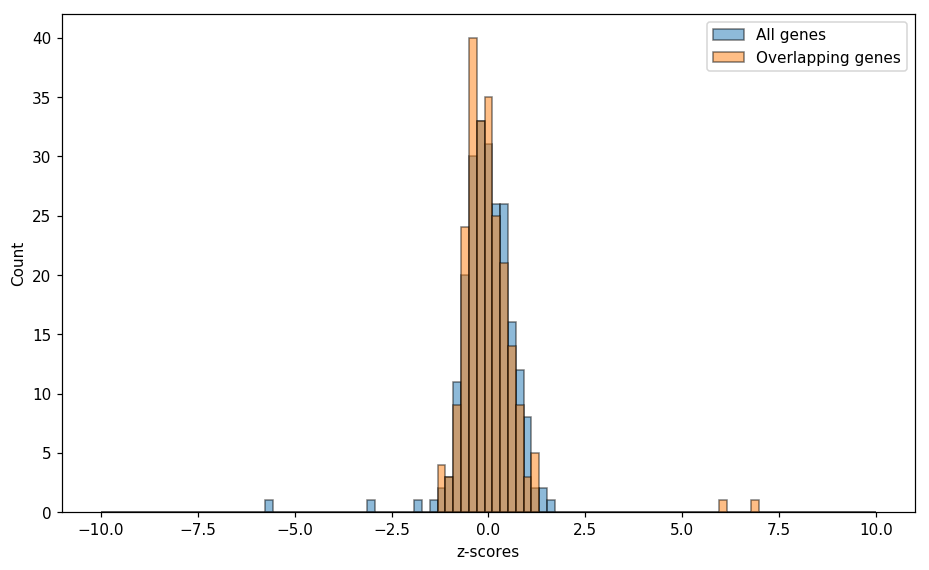

In [146]:
import matplotlib.pyplot as plt

x = np.random.choice(sig['z_score'].values, len(degs_merged))
#y = np.random.choice(sig['z_score'].values, len(degs_merged))
y = degs_merged['z_score'].values

bins = np.linspace(-10, 10, 100)

plt.figure(figsize=(10, 6), dpi=110, facecolor='w', edgecolor='k')

plt.hist(x, bins, alpha=0.5, label='All genes', edgecolor='k')
plt.hist(y, bins, alpha=0.5, label='Overlapping genes', edgecolor='k')
plt.legend(loc='upper right')
plt.xlabel('z-scores')
plt.ylabel('Count')
plt.show()

In [160]:
# https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
m1, v1 = stats.norm.fit(x)
m2, v2 = stats.norm.fit(y)
kl = np.log(np.sqrt(v2)/np.sqrt(v1)) + (v1 + (m1 - m2)**2)/(2 * v2) - 0.5
kl

0.0038580999558381901

In [175]:
brains = pd.read_csv('depressed_brains.csv').iloc[:,0]
gct = parse("norketamine.gct", make_multiindex=True)
sig = pd.concat([gct.row_metadata_df, gct.data_df.iloc[:, 0].rename('z_score')], axis=1)
brains_degs = pd.DataFrame(sig[sig['pr_gene_symbol'].isin(brains)])
brains_degs['z_score_abs'] = brains_degs['z_score'].abs()
brains_degs = brains_degs.sort_values(by=['z_score_abs'], ascending=False).drop('z_score_abs', 1)
brains_degs[brains_degs['z_score'].abs() >= 0.5]

,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing,z_score
rid,,,,,
2892,GRIA3,"glutamate receptor, ionotropic, AMPA 3",0,1,-1.4464
2890,GRIA1,"glutamate receptor, ionotropic, AMPA 1",0,1,-1.3288
4077,NBR1,neighbor of BRCA1 gene 1,0,1,-1.2959
2908,NR3C1,nuclear receptor subfamily 3 group C member 1,1,1,1.2564
7368,UGT8,UDP glycosyltransferase 8,0,1,1.2562
2560,GABRB1,"gamma-aminobutyric acid (GABA) A receptor, beta 1",0,1,-1.2236
2537,IFI6,"interferon, alpha-inducible protein 6",0,1,1.1637
8832,CD84,CD84 molecule,0,1,0.9801
3953,LEPR,leptin receptor,0,1,0.9611


In [173]:
brains_degs

,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing,z_score,z_score_abs
rid,,,,,,
2185,PTK2B,protein tyrosine kinase 2 beta,1,1,-0.1923,0.1923
6616,SNAP25,synaptosome associated protein 25kDa,1,1,-0.3183,0.3183
6347,CCL2,chemokine (C-C motif) ligand 2,1,1,0.1612,0.1612
3725,JUN,jun proto-oncogene,1,1,0.2831,0.2831
5827,PXMP2,peroxisomal membrane protein 2,1,1,0.1948,0.1948
1385,CREB1,cAMP responsive element binding protein 1,1,1,0.1099,0.1099
22809,ATF5,activating transcription factor 5,1,1,0.4061,0.4061
2908,NR3C1,nuclear receptor subfamily 3 group C member 1,1,1,1.2564,1.2564
8531,YBX3,Y-box binding protein 3,0,1,-0.1639,0.1639
